# Objective
- Build a model of housing prices in California using the California census data. 
- This data has metrics such as the population, median income, median housing price, and so on for each block group in California.
- Model should learn from this data and be able to predict the median housing price in any geographical unit, given all the other metrics.

## 1. Load Dataset

In [33]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"), engine='pyarrow')

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [34]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* There are 20640 rows in the dataset.
* total_bedroom has only 20433 non-null values i.e. we have 207 missing value for this feature.
* All features are numerical except 'ocean_proximity'  

In [35]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [36]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


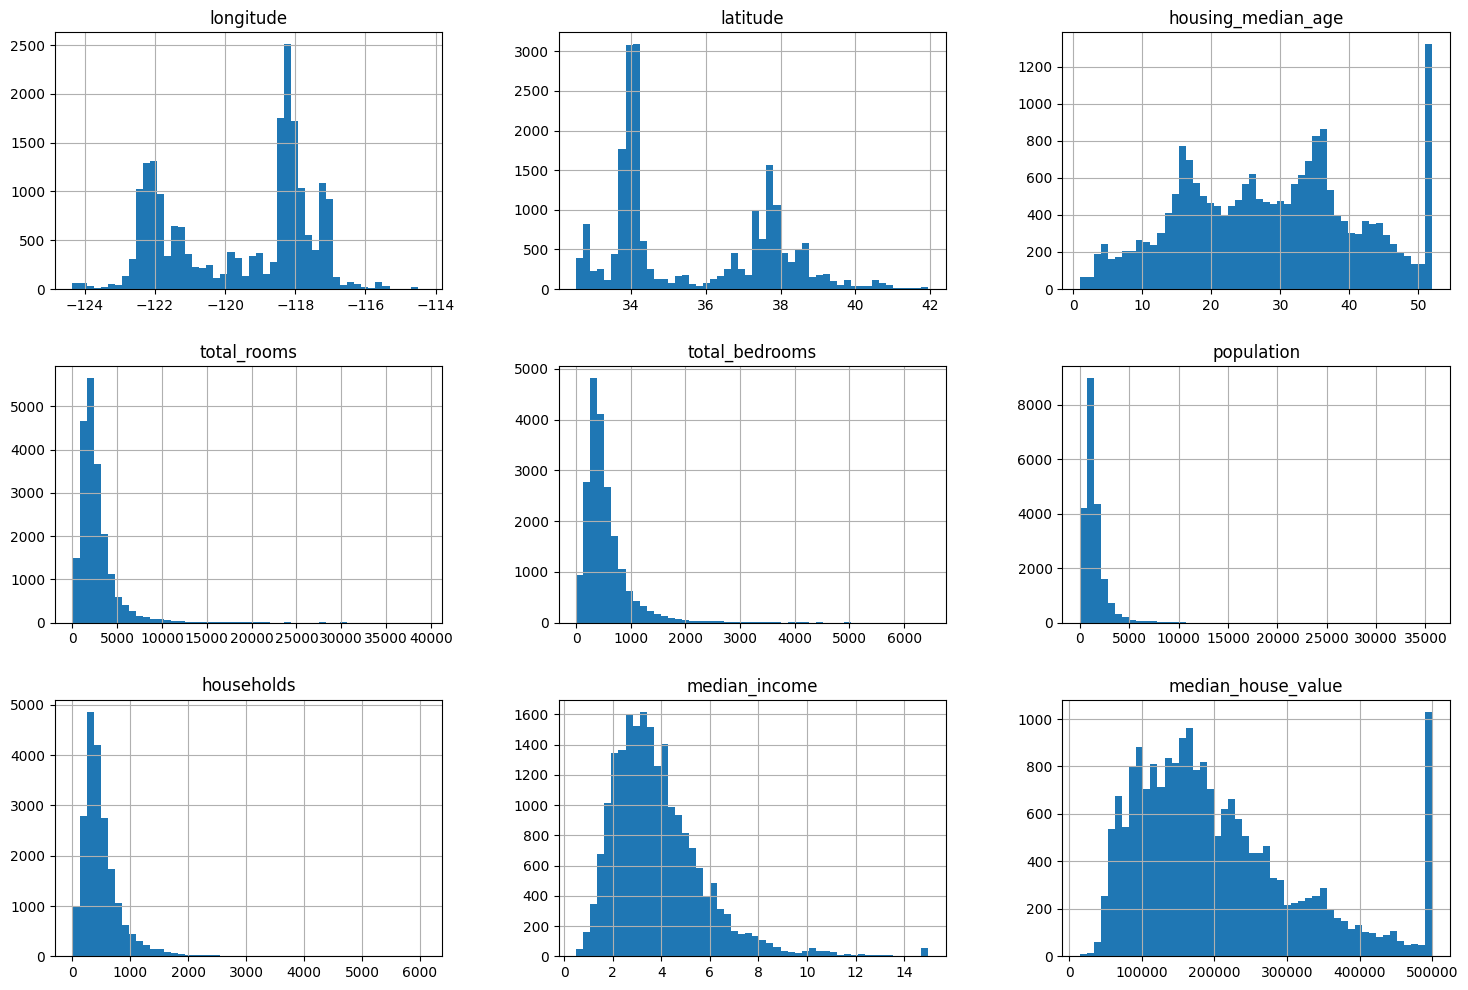

In [37]:
import matplotlib.pyplot as plt

housing.hist(bins=50,figsize=(18,12))
plt.show()

* First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, we got to know that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes.
* The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels).
* Attributes have very different scales.
* Many histograms are skewed right: they extend much farther to the right of the median than to the left. 

## 2. Create Train/Test Set

#### 2.1 Random Sampling

In [38]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [39]:
train_set.shape

(16512, 10)

In [40]:
test_set.shape

(4128, 10)

- There is significant risk of sampling bias in case of Random Samplig
- To overcome this use Stratified Sampling - divide data into homogeneous(non-overlaping) groups called strata, and right number of sample is taken from each stratum

#### 2.2 Stratified Sampling

In [41]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

<Axes: xlabel='income_cat', ylabel='count'>

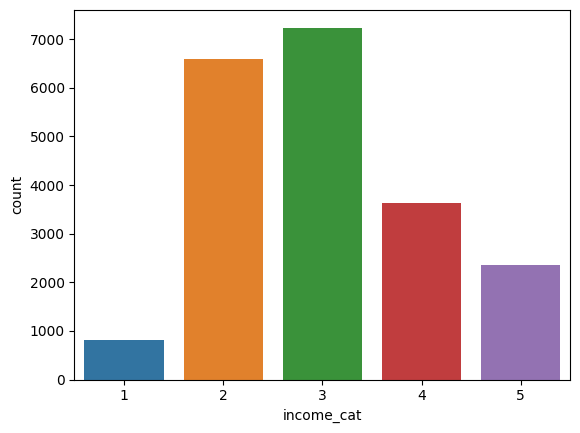

In [42]:
import seaborn as sns
sns.countplot(data=housing, x='income_cat')

In [43]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [44]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [45]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [46]:
from sklearn.model_selection import train_test_split
rand_train_set, rand_test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [47]:
rand_train_set['income_cat'].value_counts() / len(rand_train_set)

income_cat
3    0.351926
2    0.321705
4    0.174358
5    0.112827
1    0.039184
Name: count, dtype: float64

In [48]:
rand_test_set['income_cat'].value_counts() / len(rand_test_set)

income_cat
3    0.345203
2    0.307413
4    0.184109
5    0.120882
1    0.042393
Name: count, dtype: float64

In [49]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3. Explore and Visualize Dataset

In [50]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

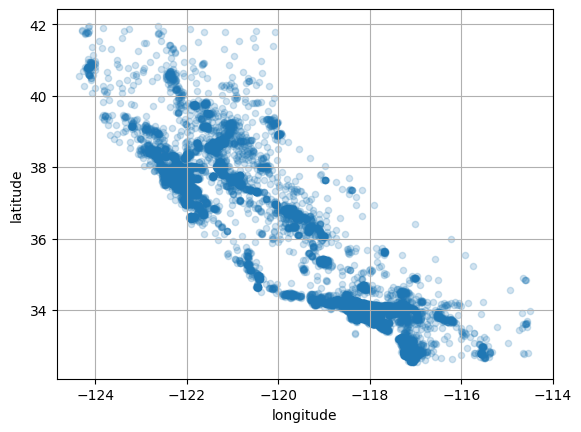

In [51]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
# Setting the alpha option to 0.2 makes it easier to visualize the places where there is a high density of data points

<Axes: xlabel='longitude', ylabel='latitude'>

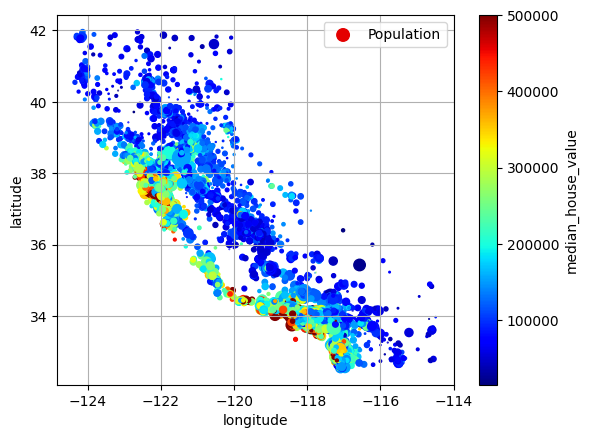

In [52]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    grid=True,
    s=housing['population']/100, # size of the point specifies the population
    label='Population',
    c='median_house_value', # color specifies the median house value based on a color map
    cmap='jet',
    colorbar=True,
    legend=True
)

In [53]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='housing_median_age', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='median_house_value', ylabel='housing_median_age'>],
       [<Axes: xlabel='housing_median_age', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='median_house_value', ylabel='total_rooms'>],
       [<Axes: xlabel='housing_median_age', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='median_house_value', ylabel='median_income'>],
       [<Axes: xlabel='housing_median_age', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='media

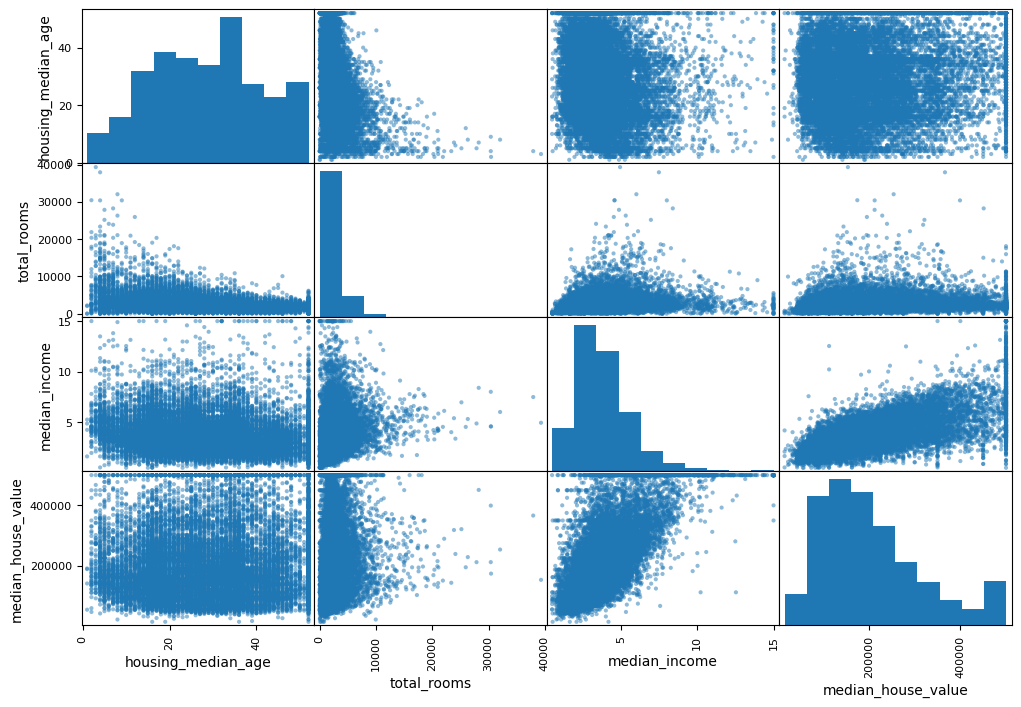

In [54]:
from pandas.plotting import scatter_matrix

attributes = ['housing_median_age', 'total_rooms', 'median_income', 'median_house_value']
scatter_matrix(housing[attributes], figsize=(12,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

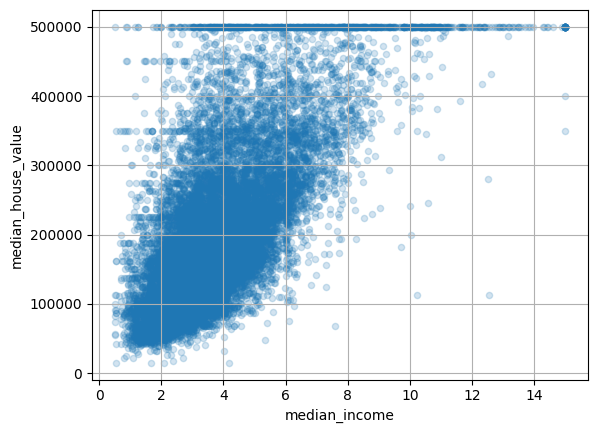

In [55]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.2, grid=True)

## 4. Experiment with Attribute Combination

In [56]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [57]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256


In [58]:
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371


In [59]:
housing['people_per_house'] = housing['population'] / housing['households']
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399


In [60]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

- bedrooms_ratio is much more coorelated with the median housing value than the total number of rooms or bedrooms.
- houses with lower bedroom/room ratio tend to be more expensive
- number of rooms per household is also much more informative than total number of rooms in a district - obviously larger the house, the more expensive they are

## 5. Prepare the Data for ML Algorithms

In [61]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### 5.1 Clean the data

We noticed earlier total_bedrooms attribute has some missing values. We have 3 options to fix this.

- Get rid of corresponding rows - dropna
- Get rid of whole column - drop
- Imputaion(zero, mean, median etc) - fillna

In [62]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
# Since the median imputer can only be applied on numerical attributes 
housing_numerical = housing.select_dtypes(include=[np.number])
imputer.fit(housing_numerical)

SimpleImputer(strategy='median')

In [63]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [64]:
housing_numerical.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

There are more powerful imputers available in the sklearn.impute package **(for numerical features only)**
- KNN Imputer - replaces missing value with the k-nearest neighbour
- Iterative Imputer - trains regression model per feature to predict the missing value based on other features

### 5.2 Handling Text and Categorical Attributes

In [65]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [66]:
from sklearn.preprocessing import OrdinalEncoder

enc =  OrdinalEncoder()
housing_cat_encoded = enc.fit_transform(X=housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [67]:
enc.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- One issue with ordinal encoding is ml algo assume 2 near value are more similar than 2 distant values
- This may be fine in some cases e.g. ordered categories 'bad' 'average' 'good' 'excellent'
- But this in not the case with ocean_proximity
- To fix this issue command solution is One-Hot Encoding

In [68]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [69]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [70]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [71]:
cat_encoder.transform(strat_test_set[['ocean_proximity']]).toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [72]:
df_output = pd.DataFrame(cat_encoder.transform(strat_test_set[['ocean_proximity']]).toarray(), columns=cat_encoder.get_feature_names_out())
df_output.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0


- If a categorical feature has **large number of possible categories** e.g. country, species then **one-hot encoding** will result in large number of input features
- This may slow down trining and degrade performance
- In this case we may replace categorical input with useful numerical feature e.g. country could be replaced with country population or GDP per capita
- Ocean proximity can be replaced with distance to the ocean

### 5.3 Feature Scaling

ML Algorithms do not perform well when input numerical attributes have different scales.

- Normalization (Min-Max Scaler)
    - feature is scaled so that it ranges from 0 to 1.  
    - Sensitive to outliers  <br>
     $$ 
     z = \frac{X-min}{max-min}
     $$
    
- Standardization (Standard Scaler)
    - centered around mean with unit std
    - less affected by outliers  <br>
    $$ {X^`} =  \frac{X-mean}{std}$$
    
    
**Note:** While the training set will always be trained to specified range, if new data containes outliers these may end up scaled outside the range. To avoid this set clip hyperparameter to True


<Axes: xlabel='population', ylabel='Count'>

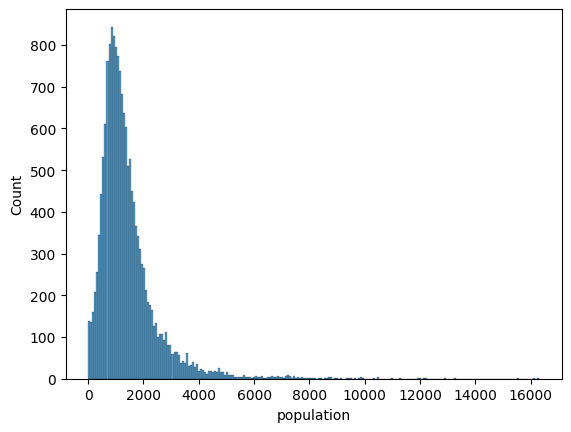

In [73]:
sns.histplot(housing.population)

- If the data is skewed normalization/standardization will sqash the output to smaller range
- So before scaling first transform it - replace the feature either with its square root or raise the feature power between 0 and 1.
- It is highly skewed log may help
- Another approach is bucketizing the feature
- When a feature is multimodal distribution( two or more peaks called modes) such as housing_median_age. It can also be helpful to bucketize it
- Another approach to transform multimodal distributions is to add feature for each of the modes(at least the main ones) representing the similarity between the housing median age and that particular mode. The similarity mode is typically computed using **Radial basis function(RBF)**

<Axes: xlabel='population', ylabel='Count'>

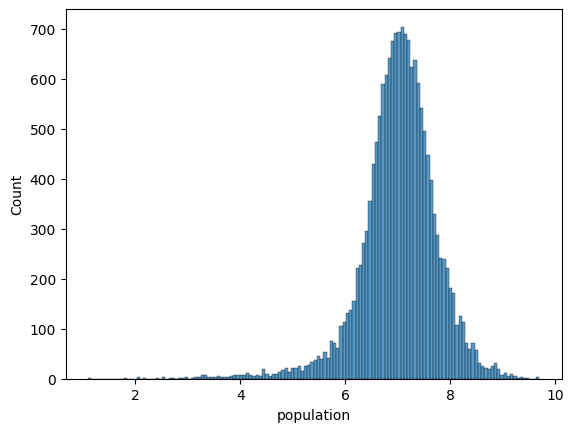

In [74]:
sns.histplot(np.log(housing.population))

<Axes: xlabel='housing_median_age', ylabel='Count'>

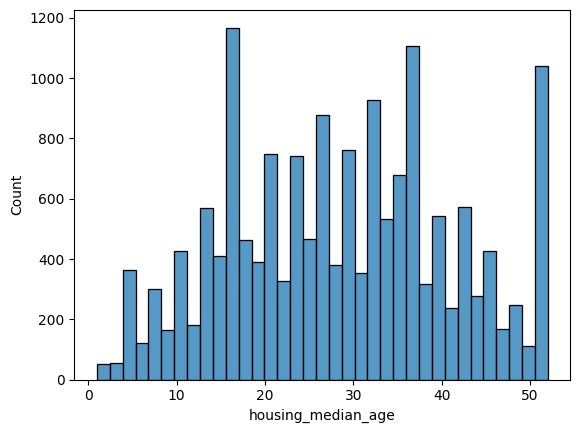

In [75]:
sns.histplot(housing.housing_median_age)

In [76]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [77]:
# Numerical Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy='median')),
            ("scaler", StandardScaler())
        ]
    )
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [78]:
# Categorical Pipeline
from sklearn.preprocessing import OneHotEncoder
catg_pipeline = Pipeline(
    steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]
    )
catg_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [79]:
# Custom Transformer that doesn't require training
# Ratio Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

In [80]:
# Log Pipeline
from sklearn.pipeline import make_pipeline
log_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log, feature_names_out='one-to-one'),
        StandardScaler()
    )
log_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('functiontransformer',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<ufunc 'log'>)),
                ('standardscaler', StandardScaler())])

In [81]:
# Custom Transformation
# Cluster Similarity
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None): # no *args or **kwargs
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None): # y is required even though we don't use it
        X = check_array(X) # Checks that X is an array with finite float values
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit() 
        return self # always return self
    
    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with training _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)] 
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
cluster_simil

ClusterSimilarity(random_state=42)

In [82]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [83]:
from sklearn.compose import ColumnTransformer, make_column_selector

preprocessing = ColumnTransformer(
        transformers=[
            ("bedrooms", ratio_pipeline(),['total_bedrooms','total_rooms']),
            ("rooms_per_house", ratio_pipeline(),['total_rooms','households']),
            ("people_per_house", ratio_pipeline(),['population','households']),
            ("log", log_pipeline,['total_rooms','total_bedrooms', 'population', 'households', 'median_income']),
            ("geo", cluster_simil, ['longitude', 'latitude']),
            ('cat', catg_pipeline,make_column_selector(dtype_include='object'))
        ], 
        remainder=num_pipeline
    )
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                             SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x0000027E2FC71D30>,
                                                                      func=<function column_ratio at 0x000002...
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['longitude', 'latitude']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000027E2E364520>)])

In [84]:
housing_prepared = preprocessing.fit_transform(housing)
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_rooms',
       'log__total_bedrooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [85]:
housing_prepared.shape

(16512, 24)

## 6. Select and Train a Model

### 6.1 Train and Evaluate on Training Set

In [86]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000027E2FC71D30>...
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027E2E364520>)])),
                ('linearregression', LinearRegression())])

In [87]:
housing_pred = lin_reg.predict(housing)
housing_pred[:5].round(-2)

array([242800., 375900., 127500.,  99400., 324600.])

In [88]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

- the first prediction is way off by $200,000
- 2 are off by 25%
- other predictions are better

In [89]:
from sklearn.metrics import mean_squared_error
'''
RMSE is the square root of MSE. 
MSE is measured in units that are the square of the target variable, 
while RMSE is measured in the same units as the target variable. 
Due to its formulation, MSE, just like the squared loss function 
that it derives from, effectively penalizes larger errors more severely.
'''
# RMSE - if squared is False
# MSE - if squared is True
lin_rmse = mean_squared_error(housing_labels, housing_pred, squared=False)
lin_rmse

68647.95686706633

In [90]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000027E2FC71D30>...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027E2E364520>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [91]:
housing_pred = tree_reg.predict(housing)

In [92]:
tree_rmse = mean_squared_error(housing_labels, housing_pred)
tree_rmse

0.0

### 6.2 Better Evaluation using Cross-Validation

In [93]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(
        estimator=tree_reg,
        X=housing,
        y=housing_labels,
        scoring='neg_root_mean_squared_error',
        cv=10
    )

pd.Series(tree_rmses).describe()

count       10.000000
mean     67329.128749
std       2383.838000
min      63747.258261
25%      65784.391892
50%      66853.634905
75%      68660.505203
max      71259.494984
dtype: float64

In [94]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(
        estimator=forest_reg,
        X=housing,
        y=housing_labels,
        scoring='neg_root_mean_squared_error',
        cv=10
    )

pd.Series(forest_rmses).describe()

count       10.000000
mean     47006.796903
std       1068.775479
min      45580.076615
25%      46391.858438
50%      47039.404321
75%      47457.808631
max      49286.348685
dtype: float64

### 6.3 Hyperparameter Tuning

In [95]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
        ('preprocessing',preprocessing),
        ('forest',RandomForestRegressor(random_state=42))
    ])
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000027E2FC71D30>,
                                                                                       fun...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027E2E364520>)])),
                ('forest', RandomForestRegressor(random_state=42))])

In [96]:
# To get the list of params run list(pipeline.get_params().keys())
param_grid = [
    {
        'preprocessing__geo__n_clusters':[5,8,10],
        'forest__max_features':[4,6,8]
    },
    {
        'preprocessing__geo__n_clusters':[10, 15],
        'forest__max_features':[6, 8, 10]
    }        
]
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_n...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000027E2E364520>)])),
                                       ('forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'forest__max_features': [4, 6, 8],
                          'preprocessing__geo__n_clusters': [5, 8, 10]},
                         {'forest__max_features': [6, 8, 10],
                          'preprocessing__geo__n_clusters': [10, 15]}],
             scoring='neg_root_mean_squared_error')

In [97]:
grid_search.best_params_

{'forest__max_features': 6, 'preprocessing__geo__n_clusters': 15}

In [98]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res = cv_res[['param_forest__max_features', 'param_preprocessing__geo__n_clusters','split0_test_score', 'split1_test_score', 'split2_test_score','mean_test_score']]
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res['mean_test_score'] = cv_res['mean_test_score'].apply(lambda x: -x)
cv_res.head()

,param_forest__max_features,param_preprocessing__geo__n_clusters,split0_test_score,split1_test_score,split2_test_score,mean_test_score
10,6,15,-43478.212139,-43871.531162,-44721.298746,44023.680682
12,8,15,-44084.987591,-43898.153369,-44945.685436,44309.608799
14,10,15,-44283.602955,-44874.446498,-45376.771658,44844.940370
5,6,10,-44598.629460,-44569.232686,-45778.178273,44982.013473
9,6,10,-44598.629460,-44569.232686,-45778.178273,44982.013473


In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_disrribs = {
        'preprocessing__geo__n_clusters':randint(low=3,high=50),
        'forest__max_features':randint(low=2, high=20)
    }

rnd_search = RandomizedSearchCV(pipeline, param_disrribs, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function r...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000027E2E364520>)])),
                                             ('forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027E30071EB0>,
                                        'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027E300711F0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [100]:
rnd_search.best_params_

{'forest__max_features': 8, 'preprocessing__geo__n_clusters': 31}

In [101]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res = cv_res[['param_forest__max_features', 'param_preprocessing__geo__n_clusters','split0_test_score', 'split1_test_score', 'split2_test_score','mean_test_score']]
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res['mean_test_score'] = cv_res['mean_test_score'].apply(lambda x: -x)
cv_res.head()

,param_forest__max_features,param_preprocessing__geo__n_clusters,split0_test_score,split1_test_score,split2_test_score,mean_test_score
0,8,31,-41634.098356,-42291.091114,-43128.617746,42351.269072
5,5,42,-41494.621115,-42670.544204,-43203.015095,42456.060138
1,16,45,-42012.543551,-42678.708160,-43109.093614,42600.115108
8,13,32,-42382.691982,-42939.153803,-43563.688021,42961.844602
6,4,24,-42537.067923,-43060.246897,-43876.854116,43158.056312


In [102]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["forest"].feature_importances_
feature_importances.round(2)

array([0.08, 0.06, 0.06, 0.01, 0.01, 0.01, 0.01, 0.19, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.04, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.01, 0.  , 0.01, 0.02,
       0.02, 0.01, 0.01, 0.02, 0.01, 0.01, 0.  , 0.08, 0.  , 0.  , 0.  ,
       0.01])

In [103]:
pd.DataFrame({'features':final_model['preprocessing'].get_feature_names_out(), 'score': feature_importances.round(2)}).sort_values(by='score', ascending=False)

,features,score
7,log__median_income,0.19
0,bedrooms__ratio,0.08
40,cat__ocean_proximity_INLAND,0.08
2,people_per_house__ratio,0.06
1,rooms_per_house__ratio,0.06
22,geo__Cluster 14 similarity,0.04
8,geo__Cluster 0 similarity,0.03
25,geo__Cluster 17 similarity,0.02
14,geo__Cluster 6 similarity,0.02
27,geo__Cluster 19 similarity,0.02


## 7. Evaluate on Test Set

In [104]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

41976.45248442275

In [105]:
# Computing 95% Confidence Interval for the generalization error 

from scipy import stats 
confidence = 0.95
squared_errors =  (final_predictions - y_test) ** 2
# Confidence interval with equal areas around the median.
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))) # stats.sem - Computes standard error of the mean.

array([39835.99605524, 44012.93610566])

## 8. Saving Model

In [106]:
import joblib
joblib.dump(final_model, 'california_housing_model.pkl')

['california_housing_model.pkl']